# 4. LSTM
## a. Load .csv dan membalikkan data yang terbalik

In [72]:
import pandas as pd
import numpy as np

# load .csv
data = pd.read_csv("USD_INR.csv")
data.index = data["Date"]
data = data.drop(columns = ["Date"], axis = 1)

print(data)

# Membalikkan data terbalik
data = data.iloc[-1::-1]
data

               Price    Open    High     Low  Change %
Date                                                  
Aug 10, 2017  64.165  63.898  64.175  63.855      0.48
Aug 09, 2017  63.860  63.780  63.860  63.710      0.26
Aug 08, 2017  63.692  63.750  63.785  63.615     -0.23
Aug 07, 2017  63.840  63.710  63.865  63.648      0.26
Aug 04, 2017  63.675  63.670  63.786  63.572     -0.05
...              ...     ...     ...     ...       ...
Jan 08, 1980   8.050   8.050   8.050   8.050      0.00
Jan 07, 1980   8.050   8.050   8.050   8.050      0.00
Jan 04, 1980   8.050   8.050   8.050   8.050      1.26
Jan 03, 1980   7.950   7.950   7.950   7.950     -0.63
Jan 02, 1980   8.000   8.000   8.000   8.000      0.00

[9697 rows x 5 columns]


,Price,Open,High,Low,Change %
Date,,,,,
"Jan 02, 1980",8.000,8.000,8.000,8.000,0.00
"Jan 03, 1980",7.950,7.950,7.950,7.950,-0.63
"Jan 04, 1980",8.050,8.050,8.050,8.050,1.26
"Jan 07, 1980",8.050,8.050,8.050,8.050,0.00
"Jan 08, 1980",8.050,8.050,8.050,8.050,0.00
...,...,...,...,...,...
"Aug 04, 2017",63.675,63.670,63.786,63.572,-0.05
"Aug 07, 2017",63.840,63.710,63.865,63.648,0.26
"Aug 08, 2017",63.692,63.750,63.785,63.615,-0.23


## b. Normalisasi data Price ke dalam range 0...1
### - Performa Prediksi Price menggunakan (Price)  di masa lalu saja karena menggunakan (Price, Open, High, Low, Change) di masa lalu tidak menunjukkan banyak perubahan signifikan
### - Sehingga saya memutuskan menggunakan (Price) di masa lalu saja karena tidak memberatkan kerja model dan perubahan performa juga tidak signifikan

In [73]:
from sklearn.preprocessing import MinMaxScaler

# Price
scaler = MinMaxScaler()
data = scaler.fit_transform(data.iloc[:,:1])

data

array([[0.00523517],
       [0.00441718],
       [0.00605317],
       ...,
       [0.91635174],
       [0.9191002 ],
       [0.92408998]])

## c. Sliding window untuk mengambil data masa lalu sebanyak window_size
### - Memprediksi Price dengan menggunakan Price di masa lalu sebanyak window_size

In [74]:
# data 10 hari terakhir
window_size = 10
x = []
y = []

for i in range (len(data) - window_size):
    x.append(data[i:(i+window_size), :1])
    y.append(data[(i+window_size), :1])

# x = data Price di masa lalu sebanyak window_size
x = np.array(x)
# y = data Price saat ini
y = np.array(y)

print(x, y)
x.shape, y.shape

[[[0.00523517]
  [0.00441718]
  [0.00605317]
  ...
  [0.00572597]
  [0.00572597]
  [0.00359918]]

 [[0.00441718]
  [0.00605317]
  [0.00605317]
  ...
  [0.00572597]
  [0.00359918]
  [0.00359918]]

 [[0.00605317]
  [0.00605317]
  [0.00605317]
  ...
  [0.00359918]
  [0.00359918]
  [0.00458078]]

 ...

 [[0.92768916]
  [0.92719836]
  [0.92343558]
  ...
  [0.91656442]
  [0.91607362]
  [0.91877301]]

 [[0.92719836]
  [0.92343558]
  [0.92327198]
  ...
  [0.91607362]
  [0.91877301]
  [0.91635174]]

 [[0.92343558]
  [0.92327198]
  [0.92466258]
  ...
  [0.91877301]
  [0.91635174]
  [0.9191002 ]]] [[0.00359918]
 [0.00458078]
 [0.00278119]
 ...
 [0.91635174]
 [0.9191002 ]
 [0.92408998]]


((9687, 10, 1), (9687, 1))

## d. Split data Train = 80%, Test = 20%

In [75]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7749, 10, 1), (1938, 10, 1), (7749, 1), (1938, 1))

## e. Membangun model LSTM dan training model
### - Model LSTM membutuhkan Dropout layer karena rawan overfitting

In [76]:
import tensorflow as tf

# build model (Input - LSTM - Dropout - Output)
# return_sequence = False karena tidak ada layer LSTM selanjutnya
# Dropout = agar model LSTM tidak overfitting
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(34, input_shape = (x.shape[1], x.shape[2]), activation = "relu", return_sequences = False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(y.shape[1]))
model.compile(loss = "mse", optimizer = "adam")

# train model
train = model.fit(x_train, y_train, epochs = 15, batch_size = 30) 

Epoch 1/15
259/259 [==============================] - 6s 8ms/step - loss: 0.0603
Epoch 2/15
259/259 [==============================] - 2s 9ms/step - loss: 0.0055
Epoch 3/15
259/259 [==============================] - 2s 7ms/step - loss: 0.0045
Epoch 4/15
259/259 [==============================] - 2s 7ms/step - loss: 0.0042
Epoch 5/15
259/259 [==============================] - 2s 8ms/step - loss: 0.0038
Epoch 6/15
259/259 [==============================] - 2s 8ms/step - loss: 0.0036
Epoch 7/15
259/259 [==============================] - 2s 8ms/step - loss: 0.0033
Epoch 8/15
259/259 [==============================] - 2s 8ms/step - loss: 0.0032
Epoch 9/15
259/259 [==============================] - 2s 7ms/step - loss: 0.0029
Epoch 10/15
259/259 [==============================] - 2s 7ms/step - loss: 0.0029
Epoch 11/15
259/259 [==============================] - 2s 7ms/step - loss: 0.0030
Epoch 12/15
259/259 [==============================] - 2s 7ms/step - loss: 0.0029
Epoch 13/15
259/259 [====

## f. Evaluate performance model dengan metrics (R2, MAE, MSE, RMSE)

In [77]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# test model
y_pred = model.predict(x_test)

# Evaluate performance
observe = pd.DataFrame()
observe["R-Square Value"] = [r2_score(y_test, y_pred)]
observe["Mean Absolute Error"] = [mean_absolute_error(y_test, y_pred)]
observe["Mean Squared Error"] = [mean_squared_error(y_test, y_pred)]
observe["Root Mean Squared Error"] = [np.sqrt(mean_squared_error(y_test, y_pred))]

observe

,R-Square Value,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
0,0.998812,0.008425,0.000098,0.009875


## g. Plot hasil data testing (Actual Price vs Predicted Price)
### - Data tersebar di tengah garis lurus menandakan hasil prediksi mendekati actual

Text(0, 0.5, 'Prediction Price')

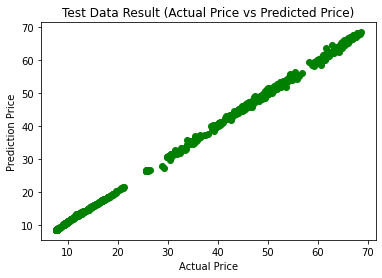

In [80]:
import matplotlib.pyplot as plt

actual = scaler.inverse_transform(y_test)
predict = scaler.inverse_transform(y_pred)

plt.scatter(actual, predict, color = "green")
plt.title("Test Data Result (Actual Price vs Predicted Price)")
plt.xlabel("Actual Price")
plt.ylabel("Prediction Price")

### - Data grafik yang mirip antara data Actual (Blue) dan data Predict (Green) 

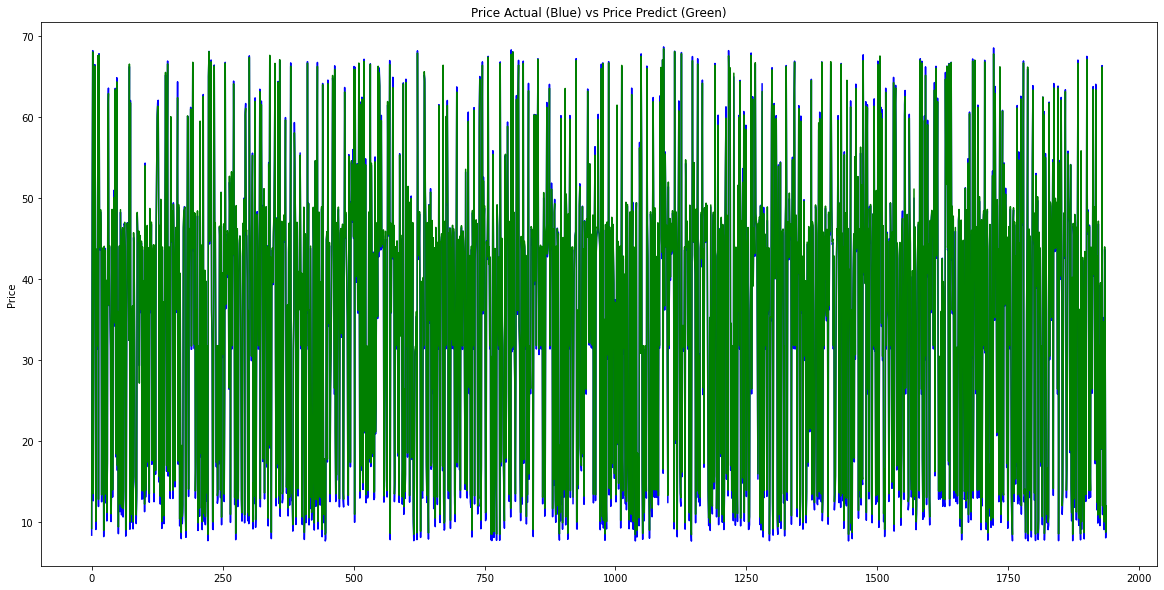

In [84]:
plt.figure(figsize = (20, 10))
plt.plot(actual, color = "b")
plt.plot(predict, color = "g")
plt.title("Price Actual (Blue) vs Price Predict (Green)")
plt.ylabel("Price")
plt.show()